<a href="https://colab.research.google.com/github/oreomcflurryyy/statistical-learning-unsupervisedlearning/blob/main/unsupervisedlearning_11_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write a Python function to perform matrix completion as in Algorithm 12.1, and as outlined in Section 12.5.2. In each iteration, the function should keep track of the relative error, as well as the iteration count. Iterations should continue until the relative error is small enough or until some maximum number of iterations is reached (set a default value for this maximum number). Furthermore, there should be an option to print out the progress in each iteration.

Test your function on the Boston data. First, standardize the features to have mean zero and standard deviation one using the `StandardScaler()` function. Run an experiment where you randomly leave out an increasing (and nested) number of observations from 5% to 30%, in steps of 5%. Apply Algorithm 12.1 with $$ M = 1, 2, \ldots, 8 $$ Display the approximation error as a function of the fraction of observations that are missing, and the value of `M` averaged over 10 repetitions of the experiment.

In [39]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

In [40]:
def matrix_completion(X, M, max_iter=15, tol=1e-4, verbose=False):
    """
    Parameters:
    - X: Incomplete data matrix with NaNs for missing values.
    - M: Number of components for approximation.
    - max_iter: Maximum number of iterations.
    - tol: Tolerance for stopping criterion based on relative error.
    - verbose: If True, print progress in each iteration.

    Returns:
    - X_filled: Completed data matrix.
    """
    # Initialize missing values with column means
    X_filled = np.where(np.isnan(X), np.nanmean(X, axis=0), X)

    for iteration in range(max_iter):
        U, s, Vt = np.linalg.svd(X_filled, full_matrices=False)

        # Keep only the first M components
        S = np.diag(s[:M])
        X_approx = U[:, :M] @ S @ Vt[:M, :]

        relative_error = np.linalg.norm(X_filled - X_approx, 'fro') / np.linalg.norm(X_filled, 'fro')
        X_filled[np.isnan(X)] = X_approx[np.isnan(X)]
        if verbose:
            print(f"Iteration {iteration + 1}, Relative Error: {relative_error:.6f}")

        # Check for convergence
        if relative_error < tol:
            break

    return X_filled

In [41]:
housing = fetch_california_housing()
X = housing.data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
def remove_data(X, fraction):
    Xna = X.copy()
    n_omit = int(fraction * X.shape[0] * X.shape[1])
    indices = [(i, j) for i in range(X.shape[0]) for j in range(X.shape[1])]
    random.shuffle(indices)
    for i, j in indices[:n_omit]:
        Xna[i, j] = np.nan

    return Xna

In [45]:
def error_calculation(fractions, M_values, n_repeats):
    errors = np.zeros((len(fractions), len(M_values)))

    for i, fraction in enumerate(fractions):
        for repeat in range(n_repeats):
            X_missing = remove_data(X_scaled, fraction)
            for j, M in enumerate(M_values):
                X_completed = matrix_completion(X_missing, M)
                error = np.linalg.norm(X_scaled - X_completed, 'fro') / np.linalg.norm(X_scaled, 'fro')
                errors[i, j] += error

    errors /= n_repeats
    return errors

In [46]:
fractions = np.arange(0.05, 0.35, 0.05)
M_values = range(1, 9)
n_repeats = 10

errors = error_calculation(fractions, M_values, n_repeats)

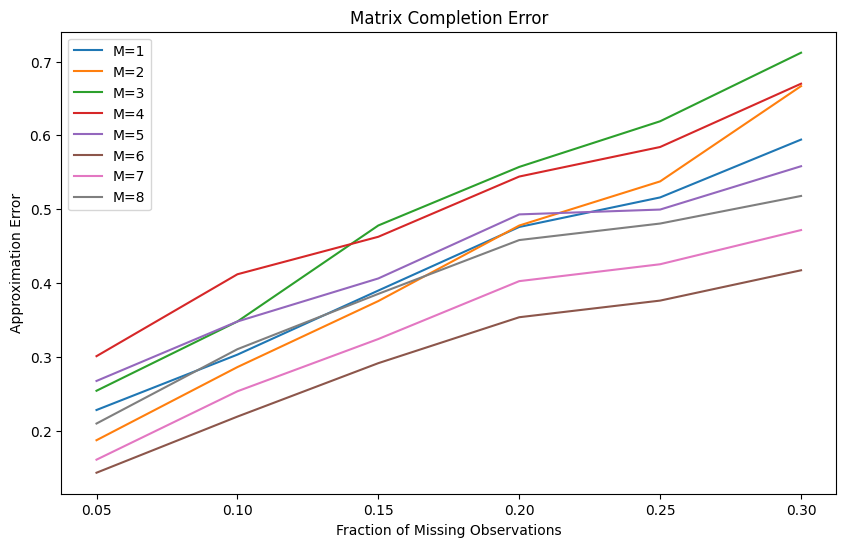

In [47]:
plt.figure(figsize=(10, 6))
for j, M in enumerate(M_values):
    plt.plot(fractions, errors[:, j], label=f'M={M}')
plt.xlabel('Fraction of Missing Observations')
plt.ylabel('Approximation Error')
plt.title('Matrix Completion Error - SVD')
plt.legend()
plt.show()

In Section 12.5.2, Algorithm 12.1 was implemented using the
`svd()` function from the np.linalg module. However, given the connection between the `svd()` function and the `PCA()` estimator highlighted in the lab, we could have instead implemented the algorithm
using `PCA()`.
Write a function to implement Algorithm 12.1 that makes use of `PCA()`
rather than `svd()`.

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA()

In [50]:
def matrix_completion(X, M, max_iter=15, tol=1e-4, verbose=False):

    X_filled = np.where(np.isnan(X), np.nanmean(X, axis=0), X)

    for iteration in range(max_iter):
        pca.fit(X_filled)
        V = pca.components_
        scores = pca.transform(X_filled)

        # Keep only the first M components
        X_approx = scores[:, :M] @ V[:M, :]

        relative_error = np.linalg.norm(X_filled - X_approx, 'fro') / np.linalg.norm(X_filled, 'fro')
        X_filled[np.isnan(X)] = X_approx[np.isnan(X)]
        if verbose:
            print(f"Iteration {iteration + 1}, Relative Error: {relative_error:.6f}")

        # Check for convergence
        if relative_error < tol:
            break

    return X_filled

In [51]:
errors = error_calculation(fractions, M_values, n_repeats)

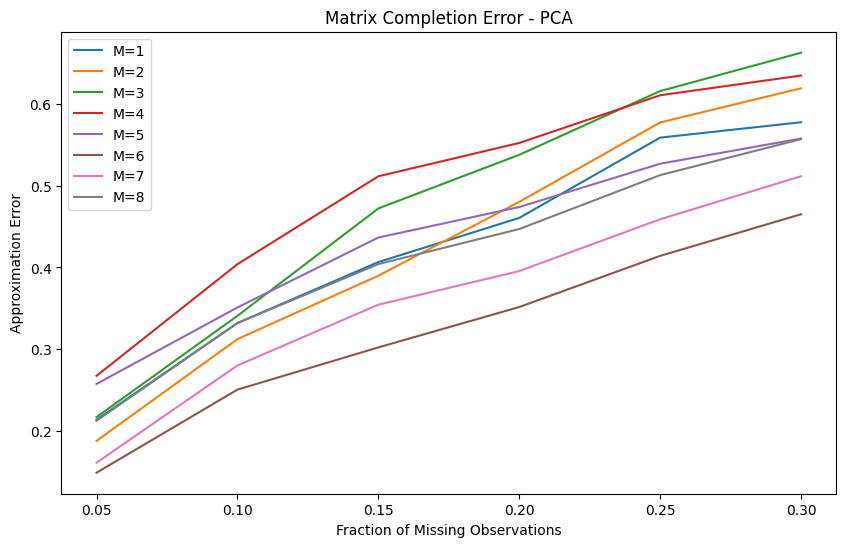

In [52]:
plt.figure(figsize=(10, 6))
for j, M in enumerate(M_values):
    plt.plot(fractions, errors[:, j], label=f'M={M}')
plt.xlabel('Fraction of Missing Observations')
plt.ylabel('Approximation Error')
plt.title('Matrix Completion Error - PCA')
plt.legend()
plt.show()